# **Model Training**

## Objectives

* Create the Machine Learning model to predict healty and powdery mildew cherry leaves to answer business requirement 2.

## Inputs

* inputs/mildew_detection_in_cherry_leaves/cherry-leaves/test.
* inputs/mildew_detection_in_cherry_leaves/cherry-leaves/train.
* inputs/mildew_detection_in_cherry_leaves/cherry-leaves/validation.

## Outputs

* Resize images.
* Image aumentation.
* Images distribution plot in train, validation, and test set.
* Create Machine learning model and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation
* Prediction of the random image file.

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 



---

## Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

## Set working directory

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection-in-cherry-leaves/jupyter_notebooks'

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection-in-cherry-leaves'

---

# Set input directories

Set train, validation and test paths.

In [5]:
my_data_dir = 'inputs/mildew_detection_in_cherry_leaves/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

---

# Set output directory

Create Output directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


### Set label names

In [7]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


---

# Resize Images

To avoid having a file bigger than 100mb to push in github, we are going to recize the all images from 256x256 to 100x100.

First we install scikit-image to use the resize function

In [8]:
%pip install scikit-image

Note: you may need to restart the kernel to use updated packages.


Create loop trough the files and plot the new standard size

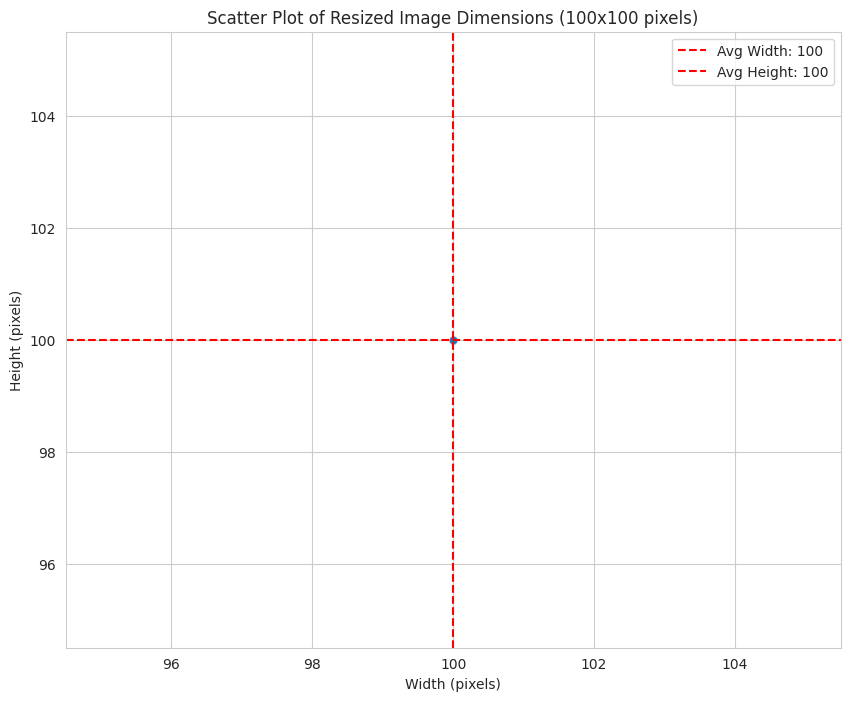

Resized Image Width: 100 pixels
Resized Image Height: 100 pixels


In [9]:
from skimage.transform import resize

# Create a dictionaty with all direcories
datasets = {
    'train': train_path,
    'test': test_path,
    'validation': val_path
}

# New size parameters
new_height, new_width = 100, 100

# New list of dimentions
dim1, dim2 = [], []

# Loop through each dataset to change the size
for dataset_name, dataset_path in datasets.items():
    # Loop through the labels
    labels = ['healthy', 'powdery_mildew']
    for label in labels:
        label_dir = os.path.join(dataset_path, label)
        for image_filename in os.listdir(label_dir):
            # Read the image
            img = imread(os.path.join(label_dir, image_filename))
            
            # Resize the image to 100x100 pixels
            img_resized = resize(img, (new_height, new_width), anti_aliasing=True)
            
            # Store the new dimensions (which will always be 100x100)
            d1, d2, colors = img_resized.shape
            dim1.append(d1)  # image height
            dim2.append(d2)  # image width

# Create scatterplot of resized image dimensions
sns.set_style("whitegrid")
fig, axes = plt.subplots(figsize=(10, 8))
sns.scatterplot(x=dim1, y=dim2, alpha=0.2)

# Set axis labels
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")

# Compute and plot mean width and height lines
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='r', linestyle='--', label=f'Avg Width: {dim1_mean}')
axes.axhline(y=dim2_mean, color='r', linestyle='--', label=f'Avg Height: {dim2_mean}')
plt.legend()

# Show the plot
plt.title("Scatter Plot of Resized Image Dimensions (100x100 pixels)")
plt.show()

# Print the average dimensions (should always be 100x100)
print(f"Resized Image Width: {dim1_mean} pixels")
print(f"Resized Image Height: {dim2_mean} pixels")

New size

In [10]:
image_average_size = (dim1_mean, dim2_mean, 3)
image_average_size

(100, 100, 3)

---

# Count number of images in train, test and validation data

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




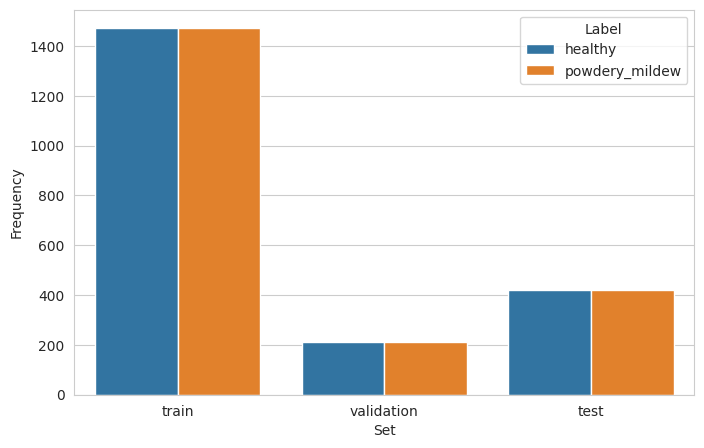

In [11]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

We selected to use a convalutional neural network to create our model. Since the amount of images is to small to train the model a data augmentaion is going to be done to increase the dataset

---

# Image Augmentation

---

## Set parameters to generate new images 

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmented_image_data = ImageDataGenerator(rotation_range=25,
                                          width_shift_range=0.20,
                                          height_shift_range=0.1,
                                          shear_range=0.1,
                                          zoom_range=0.25,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )


2024-10-05 11:38:55.253729: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-05 11:38:55.295708: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-05 11:38:55.296947: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-05 11:38:56.491352: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Augment training image dataset

In [13]:
batch_size = 20  
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_average_size[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment validation image dataset

In [14]:
batch_size = 20  
val_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                     target_size=image_average_size[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

val_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment test image dataset

In [15]:
batch_size = 20  
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                     target_size=image_average_size[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmented training images

(20, 100, 100, 3)


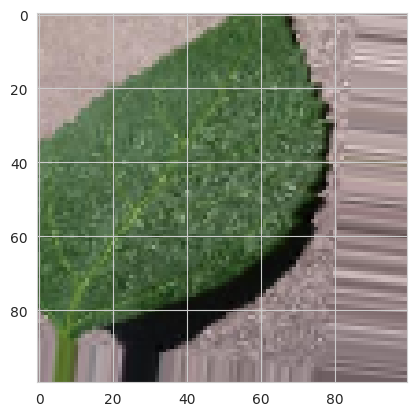

(20, 100, 100, 3)


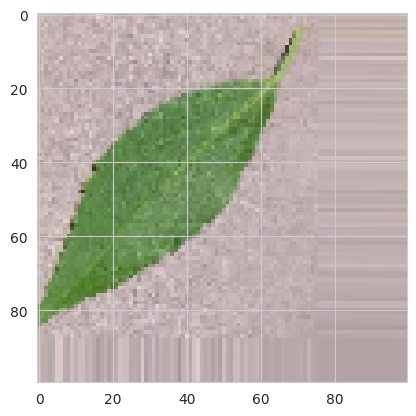

(20, 100, 100, 3)


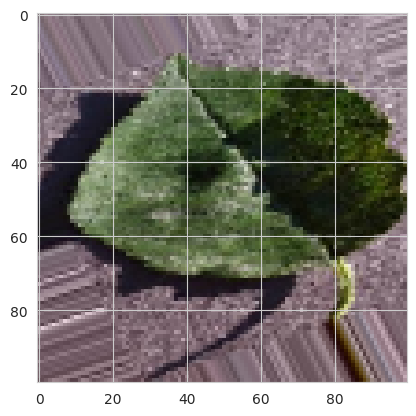

In [16]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape) # new shape with (20, 100, 100, 3)
    plt.imshow(img[0])
    plt.show()

### Plot augmented validation images

(20, 100, 100, 3)


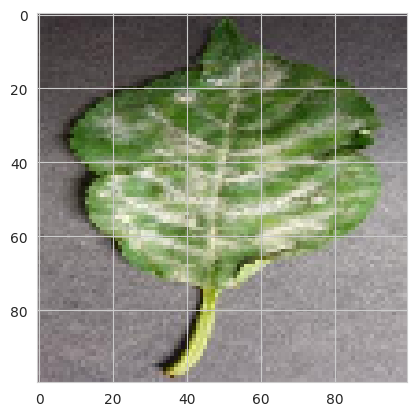

(20, 100, 100, 3)


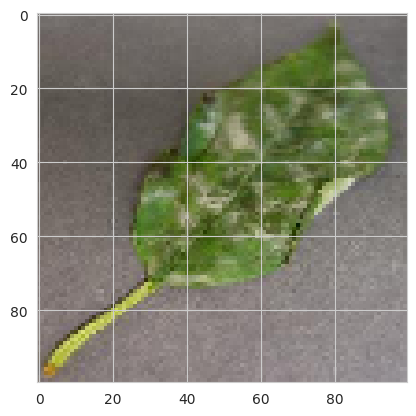

(20, 100, 100, 3)


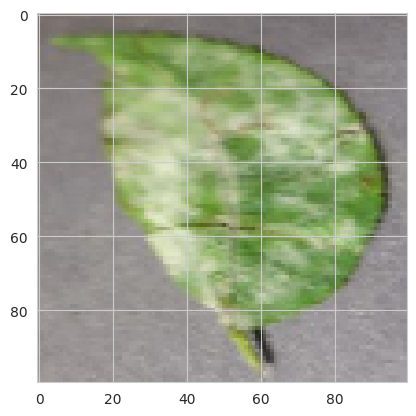

In [17]:
for _ in range(3):
    img, label = val_set.next()
    print(img.shape) # new shape with (20, 100, 100, 3)
    plt.imshow(img[0])
    plt.show()

### Plot augmented test images

(20, 100, 100, 3)


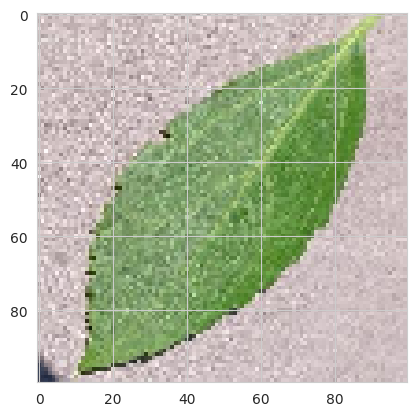

(20, 100, 100, 3)


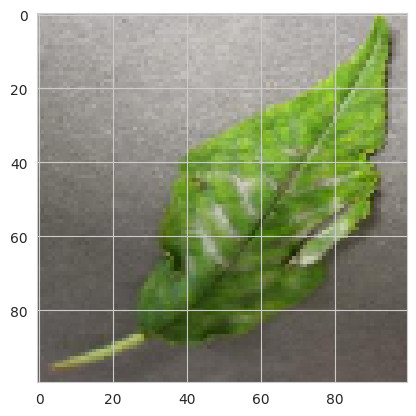

(20, 100, 100, 3)


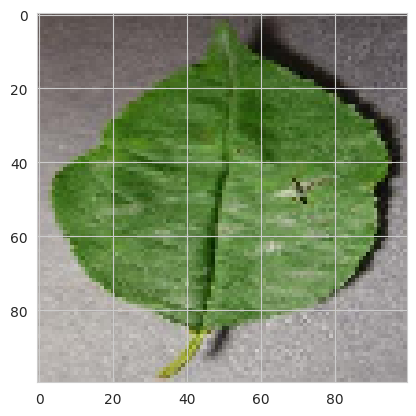

In [18]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape) # new shape with (20, 100, 100, 3)
    plt.imshow(img[0])
    plt.show()

### Save data

In [20]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

# Push files to Repo

* If you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [16]:
import os
try:
    # create here your folder
    # os.makedirs(name='')
except Exception as e:
    print(e)


IndentationError: expected an indented block (1114530593.py, line 5)